<h1>RAndom Forest Classifier<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Log-experiment-to-Neptune.ai" data-toc-modified-id="Log-experiment-to-Neptune.ai-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Log experiment to Neptune.ai</a></span></li><li><span><a href="#Chargement-des-données" data-toc-modified-id="Chargement-des-données-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Chargement des données</a></span></li><li><span><a href="#SPLITTING" data-toc-modified-id="SPLITTING-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SPLITTING</a></span></li><li><span><a href="#Métique-métier-et-scorer" data-toc-modified-id="Métique-métier-et-scorer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Métique métier et scorer</a></span><ul class="toc-item"><li><span><a href="#Scores-du-modèles-prédisant-toujours-la-classe-majoritaire" data-toc-modified-id="Scores-du-modèles-prédisant-toujours-la-classe-majoritaire-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Scores du modèles prédisant toujours la classe majoritaire</a></span></li></ul></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Random Forest Classifier</a></span><ul class="toc-item"><li><span><a href="#Evaluation-du-modéle" data-toc-modified-id="Evaluation-du-modéle-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Evaluation du modéle</a></span></li><li><span><a href="#Etude-des-differentes-options-pour-rétablir-l'équilbre-entre-les-classes" data-toc-modified-id="Etude-des-differentes-options-pour-rétablir-l'équilbre-entre-les-classes-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Etude des differentes options pour rétablir l'équilbre entre les classes</a></span><ul class="toc-item"><li><span><a href="#Pipeline-with-sampling--step" data-toc-modified-id="Pipeline-with-sampling--step-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Pipeline with sampling  step</a></span><ul class="toc-item"><li><span><a href="#Under-Sampling" data-toc-modified-id="Under-Sampling-6.2.1.1"><span class="toc-item-num">6.2.1.1&nbsp;&nbsp;</span>Under Sampling</a></span></li><li><span><a href="#Over-Sampling" data-toc-modified-id="Over-Sampling-6.2.1.2"><span class="toc-item-num">6.2.1.2&nbsp;&nbsp;</span>Over Sampling</a></span></li><li><span><a href="#Class-Weight-'balanced'" data-toc-modified-id="Class-Weight-'balanced'-6.2.1.3"><span class="toc-item-num">6.2.1.3&nbsp;&nbsp;</span>Class Weight 'balanced'</a></span></li></ul></li><li><span><a href="#Combinaison-des-trois-solutions-précédentes" data-toc-modified-id="Combinaison-des-trois-solutions-précédentes-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Combinaison des trois solutions précédentes</a></span></li></ul></li><li><span><a href="#Recherche-de-la-combinaison-optimale" data-toc-modified-id="Recherche-de-la-combinaison-optimale-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Recherche de la combinaison optimale</a></span></li><li><span><a href="#Meilleure-solution" data-toc-modified-id="Meilleure-solution-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Meilleure solution</a></span></li></ul></li><li><span><a href="#Récapitulatif-des-scores" data-toc-modified-id="Récapitulatif-des-scores-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Récapitulatif des scores</a></span></li><li><span><a href="#Sauvegarde-du-modèle-pour-dasboard" data-toc-modified-id="Sauvegarde-du-modèle-pour-dasboard-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Sauvegarde du modèle pour dasboard</a></span></li></ul></div>

# Imports



In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
pd.set_option('display.max_row', 244)
pd.set_option('display.max_column', 243)
pd.set_option('display.max_colwidth', 50)

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go


# misc libaries
import missingno as msno
bleu = (70 / 255, 130 / 255, 180 / 255)
# import dataprep.eda as eda
#import qgrid

# File system manangement
import os
import joblib 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 1
%aimport Functions
from Functions import plot_confusion_matrix, cv_score,evaluate_estimator, proba_distributions, feature_importance_plot

Loading functions ...


.... done.


In [3]:
# CONSTANTS

ITERATIONS = 5

JOBS = 2

EDA = 'EDA 1-7 all features_aggregated'


LOG = True

RESUME = True
ID_RUN = 'PROJ-9'

# Log experiment to Neptune.ai

In [4]:
import neptune.new as neptune
# import neptunecontrib.monitoring.optuna as opt_utils
import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

if LOG:
    NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkOTQ1YmNhNS1hZDYyLTRlYzQtYWU0Zi0xMjY0Yjg1MzBiMzEifQ=="
    # log to Neptune
    if RESUME:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07',
                           run=ID_RUN) # your credentials
    else:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07') # your credentials
    
    run['sys/tags'].add(EDA)
    run['sys/tags'].add('balanced')

    neptune_callback = optuna_utils.NeptuneCallback(run,
                                                    plots_update_freq=10,
                                                    log_plot_param_importances=True)   

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/m.leroy975/Projet07/e/PROJ-9
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Chargement des données




In [5]:
# local run
path='FEATURES/'
features = joblib.load ( path+EDA+'.feat')

# # Kaggle run
# path='../input/projet-07/' 
# features = joblib.load ( path+EDA+'.feat')

if LOG:
    # Name and hash of experiment features
    run['Data/Version/Features'].log(EDA)
    run['Data/Version/Features hash'].log(pd.util.hash_pandas_object(features))

Vérification du chargement

<AxesSubplot:>

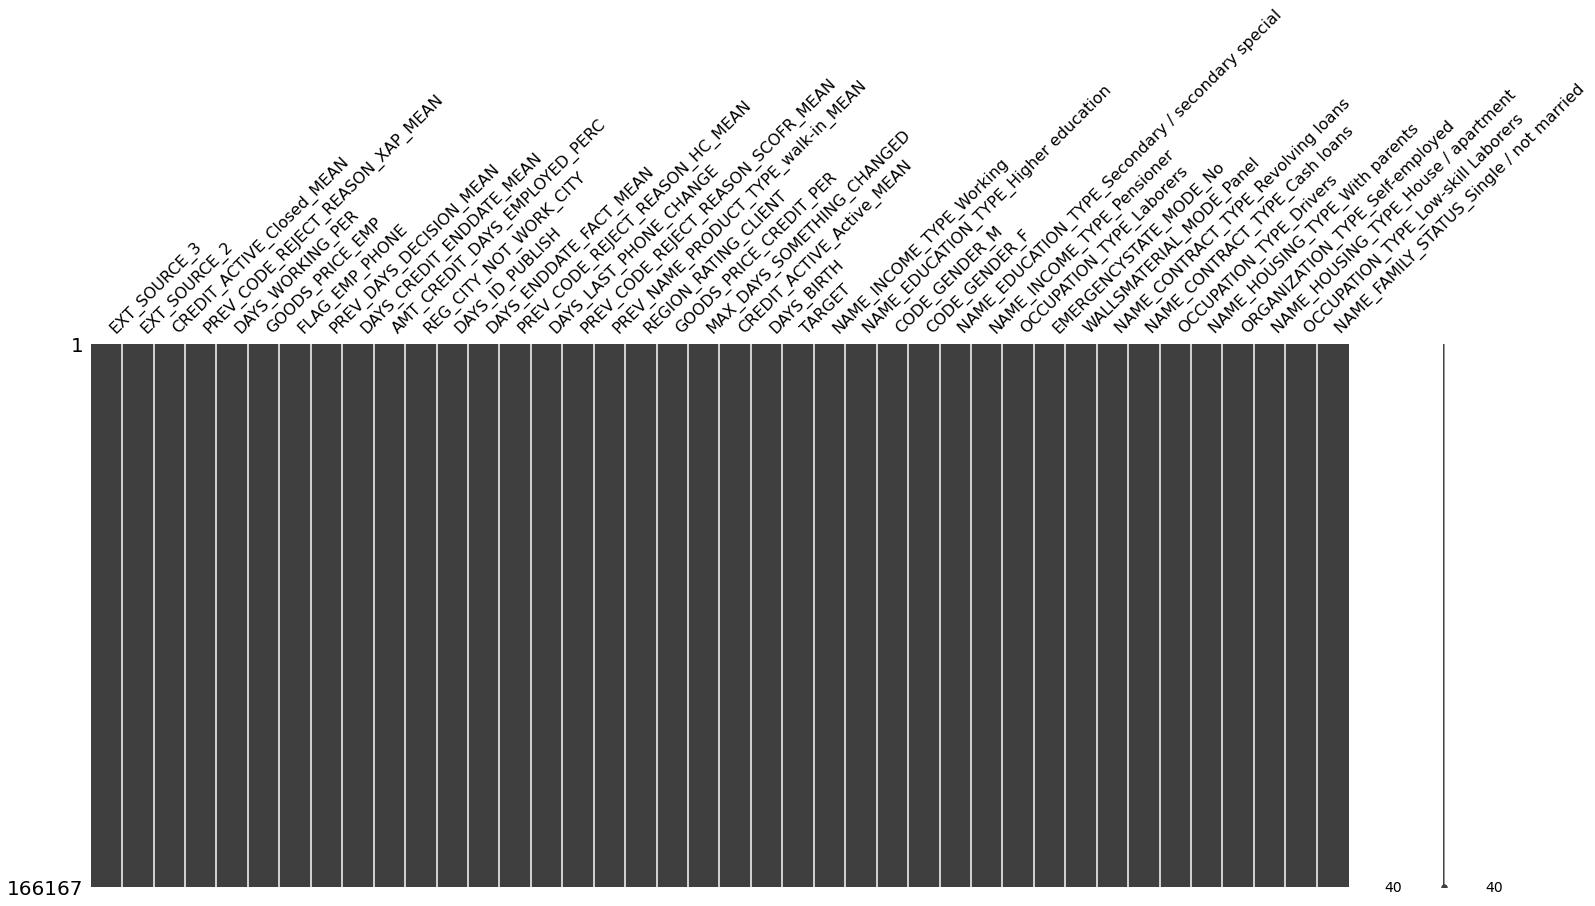

In [6]:
msno.matrix(features)

In [7]:
# Features overwiew
from collections import Counter
display(features)
print('Features shape {} x {}'.format(features.shape[0],features.shape[1]))
# TARGET ration on whole dataset
print('TARGET ratio {:.8%}'.format(features.TARGET.value_counts()[1]/features.TARGET.value_counts()[0]) )
print(Counter(features.TARGET))

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.139376,0.262949,0.750000,1.00,0.067329,0.001815,1,-606.000000,-349.000000,-0.001567,0,-2120,-697.500000,0.00,-1134.0,0.0,0.00,2,1.158397,-637.0,0.250000,-9461,1,1,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1
100004,0.729567,0.555912,1.000000,1.00,0.011814,0.001667,1,-815.000000,-488.500000,-0.001667,0,-2531,-532.500000,0.00,-815.0,0.0,0.00,2,1.000000,-225.0,0.000000,-19046,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1
100008,0.621226,0.354225,0.666667,1.00,0.093737,0.003494,1,-1192.000000,-391.333333,-0.003238,0,-477,-909.000000,0.00,-2536.0,0.0,0.00,2,1.079198,-477.0,0.333333,-16941,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0
100009,0.492060,0.724000,0.777778,1.00,0.227174,0.002244,1,-719.285714,-794.937500,-0.002005,0,-619,-1108.500000,0.00,-1562.0,0.0,0.00,2,1.118800,-619.0,0.222222,-13778,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
100010,0.540654,0.714279,0.500000,1.00,0.023820,0.000293,1,-1070.000000,-119.500000,-0.000293,1,-2379,-1138.000000,0.00,-1070.0,0.0,0.00,3,1.000000,-449.0,0.500000,-18850,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456246,0.735221,0.313334,0.666667,1.00,0.543859,0.038827,1,-897.000000,-234.666667,-0.038827,1,-4531,-1331.000000,0.00,-1516.0,0.0,0.00,2,1.000000,-4531.0,0.333333,-16063,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0
456247,0.609276,0.501221,0.727273,0.80,0.033614,0.001612,1,-1387.800000,1449.818182,-0.001155,0,-3936,-1085.000000,0.20,-2315.0,0.0,0.00,2,1.396000,-399.0,0.272727,-11870,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
456253,0.218859,0.535722,0.500000,1.00,0.529266,0.013540,1,-2380.000000,280.500000,-0.011689,1,-5150,-794.000000,0.00,-1909.0,0.0,0.00,3,1.158400,-5150.0,0.500000,-14966,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0


Features shape 166167 x 40
TARGET ratio 8.55196112%
Counter({0: 153076, 1: 13091})


In [8]:
# Descriptive Statistics of features
features.describe()

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
count,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000
mean,0.510254,0.522642,0.653379,0.862457,0.167316,0.007263,0.999958,-960.521684,530.334778,-0.006516,0.269277,-2930.144674,-948.376072,0.061706,-1068.932953,0.005888,0.081658,2.055155,1.121982,-1432.258649,0.342891,-15032.894594,0.078782,0.634380,0.268224,0.363875,0.636101,0.687832,0.000048,0.217281,0.525772,0.217841,0.093159,0.906841,0.072523,0.052080,0.142922,0.883238,0.006933,0.136549
std,0.194889,0.186316,0.224893,0.197724,0.138021,0.011067,0.006490,568.583412,2591.803993,0.009935,0.443586,1485.687941,512.259742,0.133164,825.083618,0.043194,0.177446,0.499675,0.124831,1181.062229,0.223960,3555.439786,0.269399,0.481605,0.443036,0.481115,0.481122,0.463379,0.006938,0.412397,0.499337,0.412780,0.290656,0.290656,0.259353,0.222189,0.349995,0.321138,0.082974,0.343372
min,0.000527,0.000010,0.000000,0.000000,0.000042,0.000002,0.000000,-2922.000000,-28039.000000,-0.256178,0.000000,-7197.000000,-2884.000000,0.000000,-4173.000000,0.000000,0.000000,1.000000,0.150000,-6226.000000,0.000000,-25200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.370650,0.411550,0.500000,0.750000,0.061777,0.001720,1.000000,-1297.000000,-711.000000,-0.007465,0.000000,-4239.000000,-1269.500000,0.000000,-1684.000000,0.000000,0.000000,2.000000,1.000000,-2094.000000,0.187500,-17721.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.537070,0.573477,0.666667,1.000000,0.130267,0.003899,1.000000,-845.333333,-197.000000,-0.003506,0.000000,-3076.000000,-916.000000,0.000000,-929.000000,0.000000,0.000000,2.000000,1.118800,-1094.000000,0.333333,-14834.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.667458,0.666053,0.800000,1.000000,0.234369,0.008310,1.000000,-512.464286,505.950000,-0.001541,1.000000,-1696.000000,-565.633333,0.000000,-376.000000,0.000000,0.083333,2.000000,1.198000,-495.000000,0.500000,-12168.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.885488,0.855000,1.000000,1.000000,0.728811,0.256178,1.000000,-2.000000

# SPLITTING

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(features,
                               test_size=.2,
                               random_state=42,
                               shuffle=True,
                               stratify=features.TARGET)

train_true = train.pop('TARGET')
print('train',train.shape)
print('TARGET=1 ratio on train {:.8%}'.format(train_true.value_counts()[1]/train_true.value_counts()[0]) )
test_true = test.pop('TARGET')
print('test',test.shape)
print('TARGET=1 ratio on test {:.8%}'.format(test_true.value_counts()[1]/test_true.value_counts()[0]))

train (132933, 39)
TARGET=1 ratio on train 8.55218030%
test (33234, 39)
TARGET=1 ratio on test 8.55108440%


In [10]:
if LOG:
    run['Data/Version/Train shape'].log(str(train.shape))
    run['Data/Version/Train target ratio'].log(train_true.value_counts()[1]/train_true.value_counts()[0])
    run['Data/Version/Test shape'].log(str(test.shape))
    run['Data/Version/Test target ratio'].log(test_true.value_counts()[1]/test_true.value_counts()[0])

# Métique métier et scorer

In [11]:
from sklearn.metrics import  confusion_matrix, make_scorer, roc_auc_score

# Cost weight
tn_cost = 2  ; fn_cost = -5
fp_cost = -6  ; tp_cost = 1

penalty = np.array([tn_cost,fn_cost,fp_cost,tp_cost])

# cost function
def cost(y,y_pred):
    cm = confusion_matrix(y,y_pred,normalize='true')
    return  (sum( cm.reshape(-1)*penalty)+11)/14

SCORER = {'AUC' : 'roc_auc', 'COST' : make_scorer(cost)}

In [12]:
# Worst score
true =  [0,0,1,1]
preds = [1,1,0,0] 
print('Worst cost score : ',cost(true, preds))
print('Worst roc auc score : ',roc_auc_score(true, preds))

Worst cost score :  0.0
Worst roc auc score :  0.0


In [13]:
# Best score
true =  [0,0,0,1,1,1,1,0,0,0,1,0,1]
preds = [0,0,0,1,1,1,1,0,0,0,1,0,1] 
print('Best cost score : ',cost(true, preds))
print('Best roc auc score : ',roc_auc_score(true, preds))

Best cost score :  1.0
Best roc auc score :  1.0


## Scores du modèles prédisant toujours la classe majoritaire

In [14]:
cost(train_true, [0]*len(train_true))

0.5

In [15]:
roc_auc_score(train_true, [0]*len(train_true))

0.5

# Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

MODEL = RandomForestClassifier(random_state=42, n_jobs=-1)
if LOG:
    # Name and hash of experiment features
    run['Modele/Name'] = 'RandomForest Classifier'
    run['sys/description'] = 'RandomForest'

## Evaluation du modéle 

Pipeline : 

    * min max scaler [0;1]
    * modèle
    
Scores sur 5 cross validations    

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

Class balance on fitting model step : Counter({0: 122460, 1: 10473})
TRAIN
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122460
           1       1.00      1.00      1.00     10473

    accuracy                           1.00    132933
   macro avg       1.00      1.00      1.00    132933
weighted avg       1.00      1.00      1.00    132933

 Scores  on train : {'COST': 0.5019891687962917, 'AUC': 0.7125284868373909}
TEST
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     30616
           1       0.58      0.00      0.01      2618

    accuracy                           0.92     33234
   macro avg       0.75      0.50      0.48     33234
weighted avg       0.89      0.92      0.88     33234

 Scores  on test : {'COST': 0.5019701896959463}


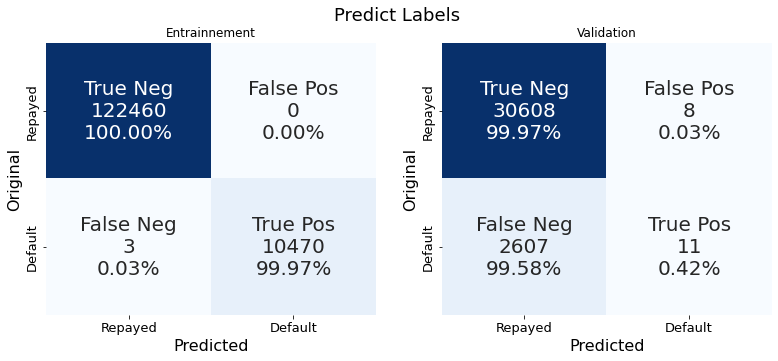

In [18]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

from imblearn.pipeline import Pipeline 

from collections import Counter


pipe = Pipeline([ 
                 ('scaler' , MinMaxScaler(feature_range=(0, 1))),
                          
                 ('model', MODEL)
                ])

# fit pipeline on train
pipe.fit(train, train_true)

# Count effective classes
print('Class balance on fitting model step : %s' % Counter(train_true))
if LOG:
    run['Modele/[Out of bag]/Classe efectives'] = str(Counter(train_true))
    
# print evaluation summary
evaluate_estimator(pipe,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Out of bag]/'))

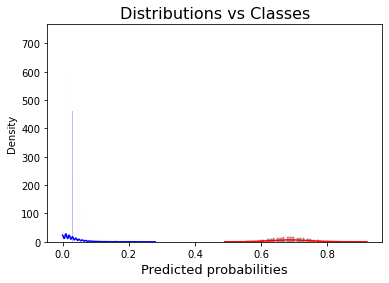

In [19]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = pipe.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Out of bag]/Train')
                   )

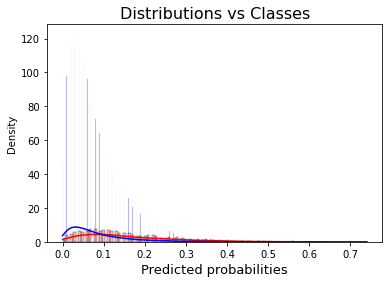

In [20]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = pipe.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Out of bag]/Test')
                   )

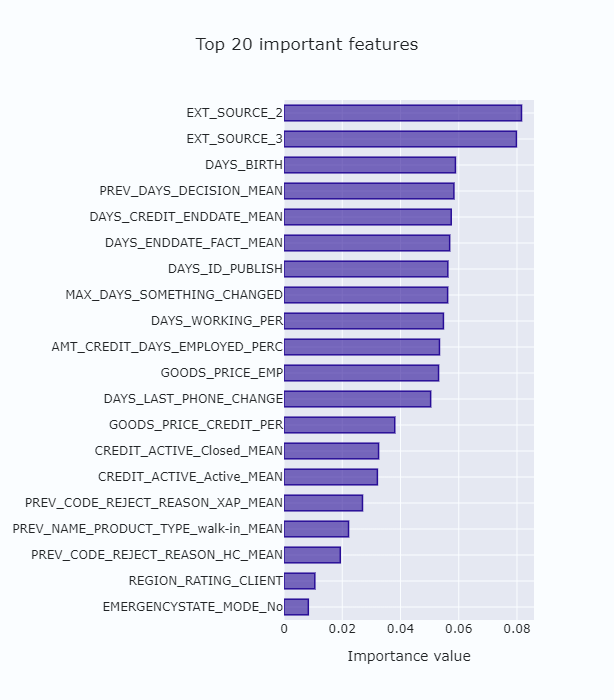

In [21]:
# Feature importance
feature_importance_plot(pipe[-1].feature_importances_,train,(LOG,run,'Modele/[Out of bag]/'))

## Etude des differentes options pour rétablir l'équilbre entre les classes

### Pipeline with sampling  step

In [22]:
pipe_samplers = Pipeline([ 
                          ('over' , None),
                          ('under' , None),
                          ('scaler' , MinMaxScaler(feature_range=(0, 1))),
                          
                          ('model', MODEL)
                     ]
                    )

#### Under Sampling

Pipeline(steps=[('over', None), ('under', RandomUnderSampler(random_state=42)),
                ('scaler', MinMaxScaler()),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

Class balance on fitting model step : Counter({0: 10473, 1: 10473})
TRAIN
               precision    recall  f1-score   support

           0       1.00      0.72      0.83    122460
           1       0.23      1.00      0.38     10473

    accuracy                           0.74    132933
   macro avg       0.62      0.86      0.60    132933
weighted avg       0.94      0.74      0.80    132933

 Scores  on train : {'COST': 0.6734179213426357, 'AUC': 0.7322855307610422}
TEST
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     30616
           1       0.15      0.65      0.25      2618

    accuracy                           0.68     33234
   macro avg       0.55      0.67      0.52     33234
weighted avg       0.89      0.68      0.76     33234

 Scores  on test : {'COST': 0.6698257331057942}


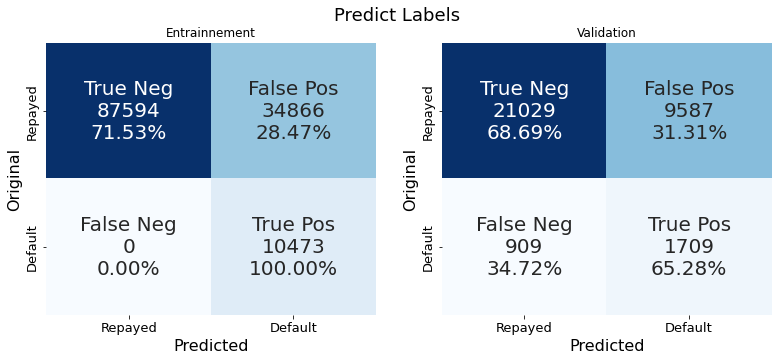

In [23]:
from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler 

pipe_under = clone(pipe_samplers)

# set pipeline set 'sampler' to RandomUnderSampler
pipe_under.set_params(**{'under': RandomUnderSampler (random_state=42) })
display(pipe_under)

# fit pipeline on train
pipe_under.fit(train, train_true)


# Count effective classes
sampled_train_true = pipe_under[0:2].fit_resample(train,train_true)[1]
print('Class balance on fitting model step : %s' % Counter(sampled_train_true))
if LOG:
    run['Modele/[Under]/Classe efectives'] = str(Counter(sampled_train_true))


evaluate_estimator(pipe_under,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Under]/')
                  )

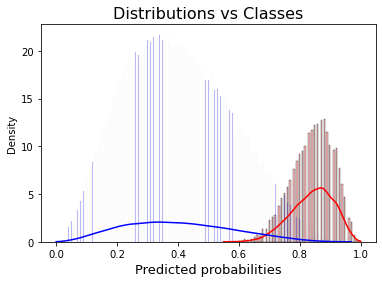

In [24]:
# Distribution of prediction probabilities versus classes on train
train_predicted_probas = pipe_under.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Under]/Train')
                   )

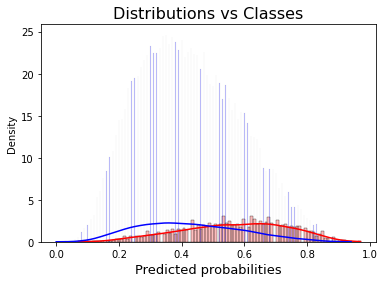

In [25]:
# Distribution of prediction probabilities versus classes on test
test_predicted_probas = pipe_under.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Under]/Test')
                   )

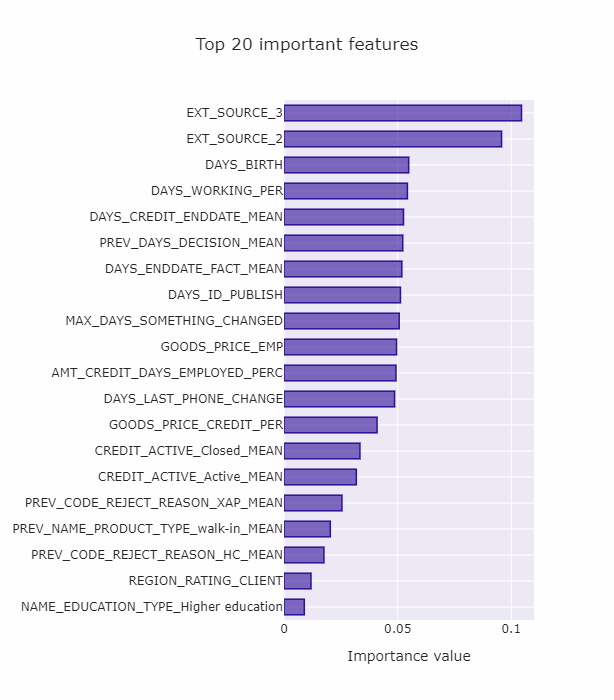

In [26]:
# Feautres importance for model
feature_importance_plot(pipe_under[-1].feature_importances_,
                        train,
                        (LOG,run,'Modele/[Under]/')
                       )

#### Over Sampling

Pipeline(steps=[('over', RandomOverSampler(random_state=42)), ('under', None),
                ('scaler', MinMaxScaler()),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

Class balance on fitting model step : Counter({0: 122460, 1: 122460})
TRAIN
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122460
           1       1.00      1.00      1.00     10473

    accuracy                           1.00    132933
   macro avg       1.00      1.00      1.00    132933
weighted avg       1.00      1.00      1.00    132933

 Scores  on train : {'COST': 0.5058934526554372, 'AUC': 0.7209750087913045}
TEST
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     30616
           1       0.48      0.02      0.03      2618

    accuracy                           0.92     33234
   macro avg       0.70      0.51      0.49     33234
weighted avg       0.89      0.92      0.89     33234

 Scores  on test : {'COST': 0.506937172213114}


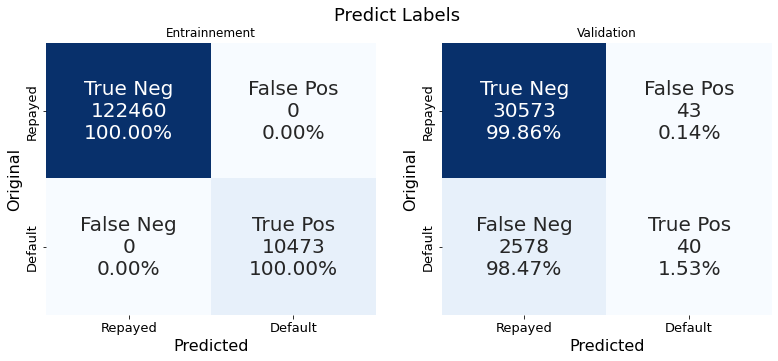

In [27]:
from imblearn.over_sampling import RandomOverSampler 

pipe_over = clone(pipe_samplers)

# set pipeline set 'sampler' to RandomOverSampler
pipe_over.set_params(**{'over': RandomOverSampler (random_state=42) })
display(pipe_over)

# fit pipeline on train
pipe_over.fit(train, train_true)

# Count effective classes
sampled_train_true = [0,1]*train_true.value_counts()[0] #pipe_over[0:2].fit_resample(train,train_true)[1]
print('Class balance on fitting model step : %s' % Counter(sampled_train_true))
if LOG:
    run['Modele/[Over]/Classe efectives'] = str(Counter(sampled_train_true))

# evaluate
evaluate_estimator(pipe_over,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Over]/')
                  )

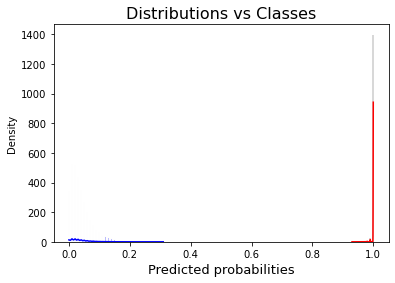

In [28]:
# Distribution of prediction probabilities versus classes on train
train_predicted_probas = pipe_over.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Over]/Train')
                   )

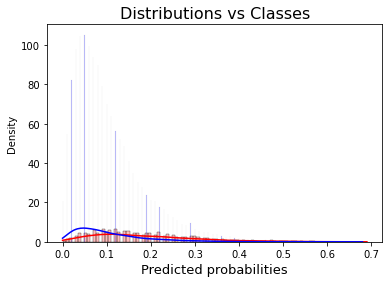

In [29]:
# Distribution of prediction probabilities versus classes on test
test_predicted_probas = pipe_over.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Over]/Test')
                   )

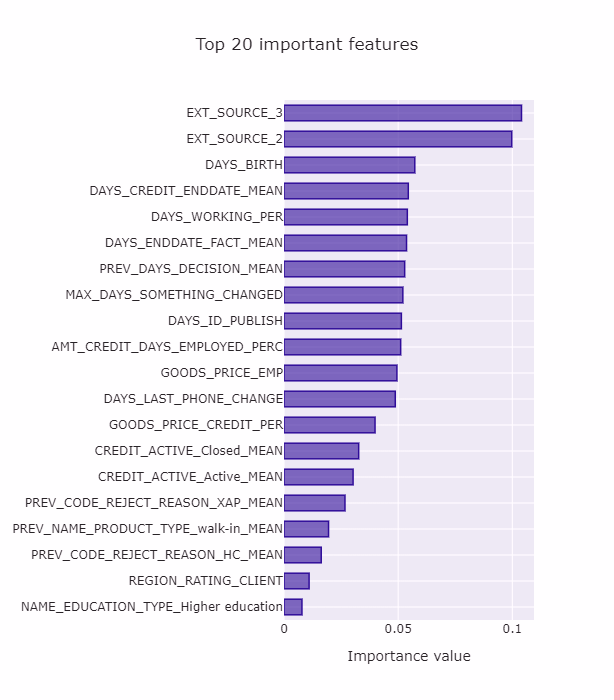

In [30]:
# Feautres importance for model
feature_importance_plot(pipe_over[-1].feature_importances_,
                        train,
                        (LOG,run,'Modele/[Over]/')
                       )

#### Class Weight 'balanced'

Pipeline(steps=[('over', None), ('under', None), ('scaler', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

Class balance on fitting model step : Counter({0: 122460, 1: 10473})
TRAIN
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122460
           1       1.00      1.00      1.00     10473

    accuracy                           1.00    132933
   macro avg       1.00      1.00      1.00    132933
weighted avg       1.00      1.00      1.00    132933

 Scores  on train : {'COST': 0.5004393857676291, 'AUC': 0.7171595465308727}
TEST
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     30616
           1       0.50      0.00      0.00      2618

    accuracy                           0.92     33234
   macro avg       0.71      0.50      0.48     33234
weighted avg       0.89      0.92      0.88     33234

 Scores  on test : {'COST': 0.5005239624652388}


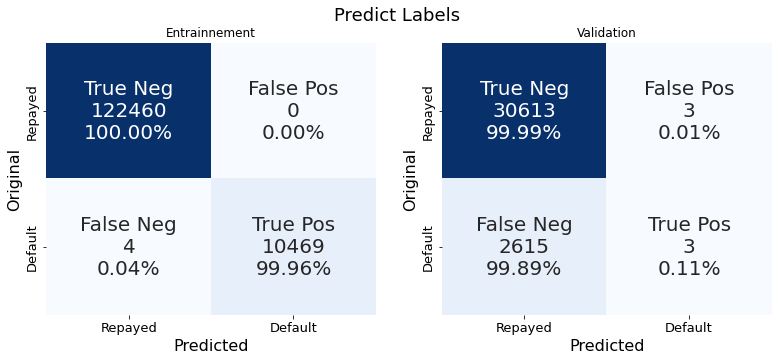

In [31]:

pipe_balance = clone(pipe_samplers)

# fit pipeline on train with sample_weight
pipe_balance.set_params(**{'model__class_weight': 'balanced'})
display(pipe_balance)

# fit pipeline on train
pipe_balance.fit(train, train_true)

# Count effective classes
print('Class balance on fitting model step : %s' % Counter(train_true))
if LOG:
    run['Modele/[Balance]/Classe efectives'] = str(Counter(train_true))

# evaluate
evaluate_estimator(pipe_balance,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Balance]/')
                  )


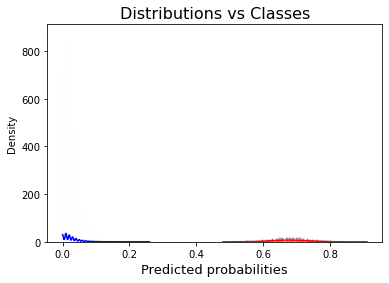

In [32]:
# Distribution of prediction probabilities versus classes on train
train_predicted_probas = pipe_balance.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Balance]/Train')
                   )

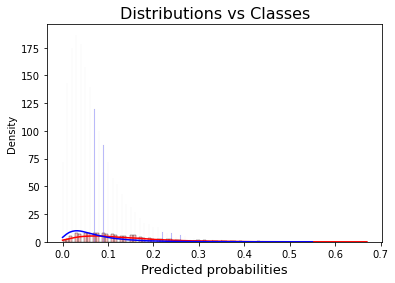

In [33]:
# Distribution of prediction probabilities versus classes on test
test_predicted_probas = pipe_balance.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Balance]/Test')
                   )

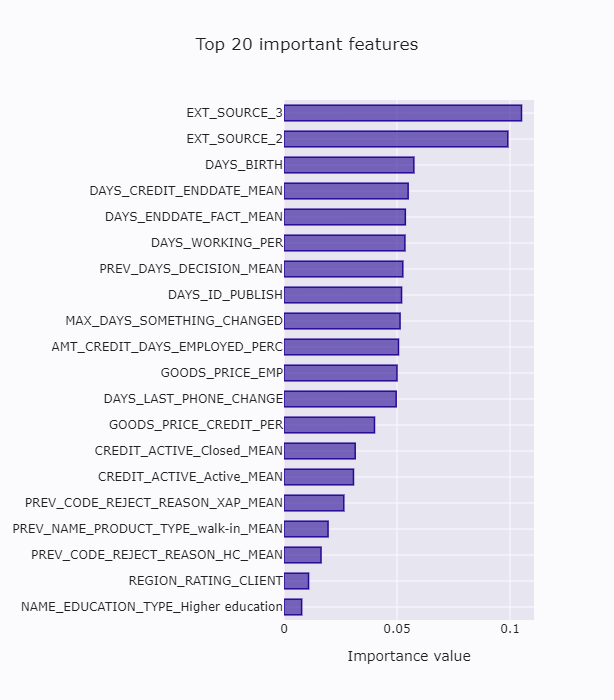

In [34]:
# Feautres importance for model
feature_importance_plot(pipe_balance[-1].feature_importances_,
                        train,
                        (LOG,run,'Modele/[Balance]/')
                       )

### Combinaison des trois solutions précédentes

Pour rééquilibrer les classes:

    * undersampler classe majoritaire en ne prenant que 75% des samples de cette classe
    
    * oversampler classe ninoritaire en duplicant 25% des samples de cette classe
    
    * pondérer les individus en fonction de leur appartenance à majority ou miority (option 'balanced' du modèle)





Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy=0.10690225379715826)),
                ('under',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy=0.14253633839621102)),
                ('scaler', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

Class balance on fitting model step : Counter({0: 91843, 1: 13091})
TRAIN
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122460
           1       1.00      1.00      1.00     10473

    accuracy                           1.00    132933
   macro avg       1.00      1.00      1.00    132933
weighted avg       1.00      1.00      1.00    132933

 Scores  on train : {'COST': 0.5034686411820463, 'AUC': 0.7239051691174154}
TEST
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     30616
           1       0.51      0.01      0.02      2618

    accuracy                           0.92     33234
   macro avg       0.72      0.50      0.49     33234
weighted avg       0.89      0.92      0.88     33234

 Scores  on test : {'COST': 0.5036840685866955}


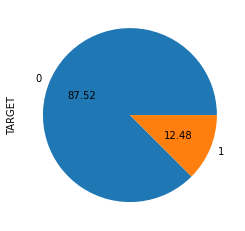

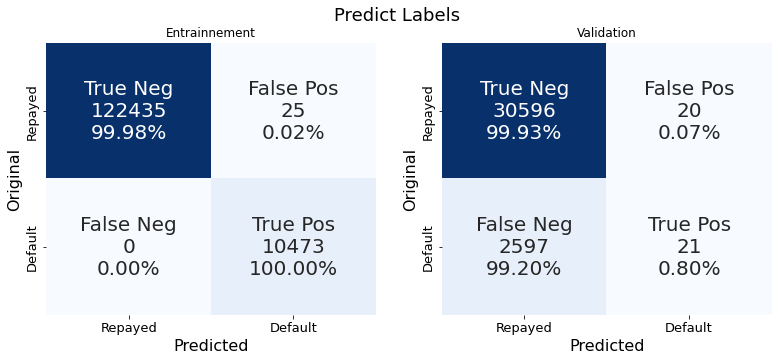

In [35]:
# Initial ratio between classes
ratio_initial = train_true.value_counts()[1]/train_true.value_counts()[0]

# Sampling factors
over = .25
under = .75
# Compute strategy for samplers
over_strategy = ratio_initial *(1 + over)
under_strategy = ratio_initial *(1 + over)/( under)

# set pipeline over and under 
pipe_samplers.set_params(**{'over': RandomOverSampler (random_state=42,sampling_strategy=over_strategy),
                        'under': RandomUnderSampler (random_state=42,sampling_strategy=under_strategy),
                        'model__class_weight': 'balanced'})
display(pipe_samplers)

# fit pipeline on train
pipe_samplers.fit(train, train_true)

# Count effective classes
sampled_train_true = pipe_samplers[0:2].fit_resample(train,train_true)[1]

print('Class balance on fitting model step : %s' % Counter(sampled_train_true))

sampled_train_true.value_counts().plot.pie(autopct='%.2f')
if LOG:
    run['Modele/[Samplers & Weight]/Classe efectives'] = str(Counter(pipe_samplers[0:2].fit_resample(train,train_true)[1]))


# evaluate
evaluate_estimator(pipe_samplers,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Samplers & Weight]/'))

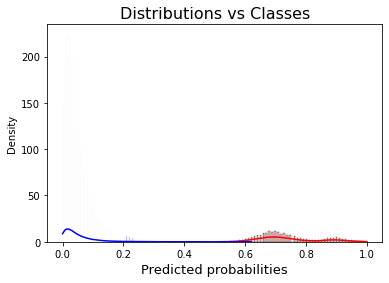

In [36]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = pipe_samplers.predict_proba(train)
proba_distributions(train_true,train_predicted_probas,(LOG,run,'Modele/[Samplers & Weight]/Train'))

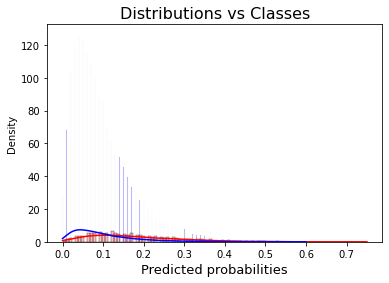

In [37]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = pipe_samplers.predict_proba(test)
proba_distributions(test_true,test_predicted_probas,(LOG,run,'Modele/[Samplers & Weight]/Test'))

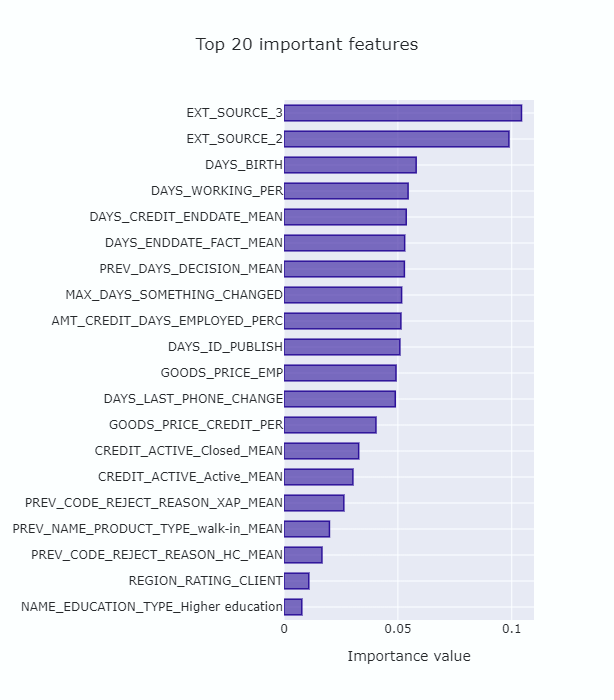

In [38]:
feature_importance_plot(pipe_samplers[-1].feature_importances_,train,(LOG,run,'Modele/[Samplers & Weight]/'))

Le modèle overfit .

Grid search pour déterminer la meilleure approche

## Recherche de la combinaison optimale

In [39]:
from sklearn.preprocessing import StandardScaler  # MODIFIE
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

from joblib import Memory
from shutil import rmtree
# Create a temporary folder to store the transformers of the pipeline
# location = 'cachedir1'
# memory = Memory(location=location, verbose=0)


# Reset pipeline parameters
pipe_optim = Pipeline([ 
                            ('over' , RandomOverSampler (random_state=42)),
                            ('under' , RandomUnderSampler(random_state=42)),
                            ('scaler' , None),

                            ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
                        ],
#                         memory=memory
                       )

In [40]:
pipe_optim.get_params()

{'memory': None,
 'steps': [('over', RandomOverSampler(random_state=42)),
  ('under', RandomUnderSampler(random_state=42)),
  ('scaler', None),
  ('model', RandomForestClassifier(n_jobs=-1, random_state=42))],
 'verbose': False,
 'over': RandomOverSampler(random_state=42),
 'under': RandomUnderSampler(random_state=42),
 'scaler': None,
 'model': RandomForestClassifier(n_jobs=-1, random_state=42),
 'over__random_state': 42,
 'over__sampling_strategy': 'auto',
 'over__shrinkage': None,
 'under__random_state': 42,
 'under__replacement': False,
 'under__sampling_strategy': 'auto',
 'model__bootstrap': True,
 'model__ccp_alpha': 0.0,
 'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': None,
 'model__max_features': 'auto',
 'model__max_leaf_nodes': None,
 'model__max_samples': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_impurity_split': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__min_weight_fraction_leaf': 0.0,
 'mode

In [41]:
### fonction to maximize
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.base import clone

ratio_initial = train_true.value_counts()[1]/train_true.value_counts()[0]
std = StandardScaler()
mmx = MinMaxScaler(feature_range=(0, 1))
qt = QuantileTransformer(n_quantiles=10000,
                        output_distribution='normal',
                        ignore_implicit_zeros=False,
                        subsample=100000,
                        random_state=42)
rob = RobustScaler(with_centering=True,
                        with_scaling=True,
                        quantile_range=(25.0, 75.0),
                        copy=True,
                        unit_variance=True)
pwt = PowerTransformer(method='yeo-johnson',
                     standardize=True,
                     copy=True)

def Opt_search(trial):
    # the function gets a set of variable parameters in "param"
    # we use theses params to set pipeline params
    
    # Initialize params
    params = {}
    pipe = clone(pipe_optim)
    
    # Variance space
#     params['variance__threshold'] = trial.suggest_float('variance', 0, .1)  # MODIFIE
    
    # ratios for samplers
    o_r = trial.suggest_float('ratio_over', 0, 1)
    u_r = trial.suggest_float('ratio_under', .5, 1)
    
    #over sampling
    params['over__sampling_strategy'] =  ratio_initial *(1 + o_r)
    
    # under sampling
    params['under__sampling_strategy'] = ratio_initial *(1 + o_r)/( u_r) 
    
    # sample weight
#     x = trial.suggest_float('weight',0.5,0.99)  # MODIFIE
#     params['model__class_weight'] = {0 : 1-x, 1 : x}
    params['model__class_weight'] = 'balanced'
        
    # Scaller space
    scaler_name = trial.suggest_categorical('scaller name', ['StandardScaler',
                                                             'MinMaxScaler',
                                                             'QuantileTransformer',
                                                             'RobustScaler',
                                                             'PowerTransformer'
                                                            ])
    if scaler_name == 'MinMaxScaler':
        params['scaler'] = mmx
                                             
    elif scaler_name == 'StandardScaler':
        params['scaler'] =  std   
        
    elif scaler_name == 'QuantileTransformer':
        params['scaler'] =  qt
        
    elif scaler_name == 'RobustScaler':
        params['scaler'] =  rob
        
    elif scaler_name == 'PowerTransformer':
        params['scaler'] =  pwt
        
    # Random Forest space       
    params['model__max_depth'] = trial.suggest_int('model__max_depth',2,10)
    params['model__n_estimators'] = trial.suggest_int('model__n_estimators',10,200)
    params['model__criterion'] = trial.suggest_categorical('model__criterion',['gini','entropy'])
    params['model__max_features'] = trial.suggest_categorical('model__max_features',['sqrt','log2','auto'])
#     params['model__warm_start'] = trial.suggest_categorical('model__warm_start',[False,True])
    params['model__oob_score'] = trial.suggest_categorical('model__oob_score',[False, True])
            
#     print(params)
    
    # we use theses params to set pipeline params
    pipe.set_params(**params)
    
    #     print(pipe.get_params(deep=False))
               
    # score
    score = cross_validate(pipe,
                           train,
                           train_true,
                           scoring=SCORER,
                           n_jobs=1,
                           cv=cv)
    
    print('> cv cost score mean: %.4f (\u00B1 %.4f) <> roc auc score mean: %.4f (\u00B1 %.4f) < ' % (
                                                                                        score['test_COST'].mean(),
                                                                                        score['test_COST'].std(),
                                                                                        score['test_AUC'].mean(),
                                                                                        score['test_AUC'].std()
                                                                                       )
         )
    
    if LOG:
        run['AUC'].log(score['test_AUC'].mean())
        run['COST'].log(score['test_COST'].mean())
        
    return score['test_COST'].mean()

In [42]:
# Verify pipeline before optimize
pipe_optim.get_params(deep=False)

{'memory': None,
 'steps': [('over', RandomOverSampler(random_state=42)),
  ('under', RandomUnderSampler(random_state=42)),
  ('scaler', None),
  ('model', RandomForestClassifier(n_jobs=-1, random_state=42))],
 'verbose': False}

In [43]:
# Create study the first time or append existing
import os.path
from os import path
import optuna
from optuna.samplers import TPESampler


# Studiing n_iter times
n_iter = ITERATIONS

# Optimize
if LOG and RESUME:
    # Load Optuna Study from the Neptune Run
    study = optuna_utils.load_study_from_run(run)  
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
elif LOG and not RESUME:
    name = 'RFC '+EDA
    study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 50)
                                   )
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
    
else:
    # Local run
    save_path = 'Studies/'
    name =save_path+'NEWRUN_rfc_'+EDA+'reg_COST1'
    file_name = name+'.study'

    if path.exists(file_name):
        # load study
        study = joblib.load(file_name)
        print('Loading {}'.format(file_name))

        # Load Optuna Study from the Neptune Run
    #     study = optuna_utils.load_study_from_run(run)

    else:
        # Otherwise create study
        print('Creating a new study named {}'.format(name))
        study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 10)
                                   )
        
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS)

# # save the sutdy 
# joblib.dump(study, file_name)

# print best results
print('Best custom_score = {} for :\n'.format(study.best_value))

for key, value in study.best_params.items():
    print("    {}: {}".format(key, value))

[I 2021-07-28 12:25:22,849] Trial 290 finished with value: 0.6741696661085314 and parameters: {'ratio_over': 0.24743891685613534, 'ratio_under': 0.5702753938222246, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 176, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6742 (± 0.0042) <> roc auc score mean: 0.7371 (± 0.0051) < 


[I 2021-07-28 12:26:04,793] Trial 291 finished with value: 0.6742101310474483 and parameters: {'ratio_over': 0.23971867773523647, 'ratio_under': 0.5671344381275468, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 178, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6742 (± 0.0038) <> roc auc score mean: 0.7374 (± 0.0052) < 


[I 2021-07-28 12:27:11,674] Trial 292 finished with value: 0.6746520272844279 and parameters: {'ratio_over': 0.6225876826654354, 'ratio_under': 0.5810995841122247, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 181, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6747 (± 0.0049) <> roc auc score mean: 0.7370 (± 0.0054) < 


[I 2021-07-28 12:27:12,779] Trial 293 finished with value: 0.6739421701503774 and parameters: {'ratio_over': 0.44959097794109304, 'ratio_under': 0.5387044051669891, 'scaller name': 'QuantileTransformer', 'model__max_depth': 6, 'model__n_estimators': 182, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6739 (± 0.0053) <> roc auc score mean: 0.7356 (± 0.0055) < 


[I 2021-07-28 12:27:51,502] Trial 294 finished with value: 0.6741416771794151 and parameters: {'ratio_over': 0.4182286850329593, 'ratio_under': 0.5541247210399758, 'scaller name': 'QuantileTransformer', 'model__max_depth': 6, 'model__n_estimators': 189, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6741 (± 0.0033) <> roc auc score mean: 0.7358 (± 0.0052) < 
Best custom_score = 0.6773052025674776 for :

    ratio_over: 0.44477364180855467
    ratio_under: 0.5713605874395502
    scaller name: QuantileTransformer
    model__max_depth: 7
    model__n_estimators: 180
    model__criterion: gini
    model__max_features: log2
    model__oob_score: True


In [44]:
# Log Optuna Study metadata
if LOG:
#     optuna_utils.log_study_metadata(study, run)
    run['_So far executed trials'] = len(study.trials)

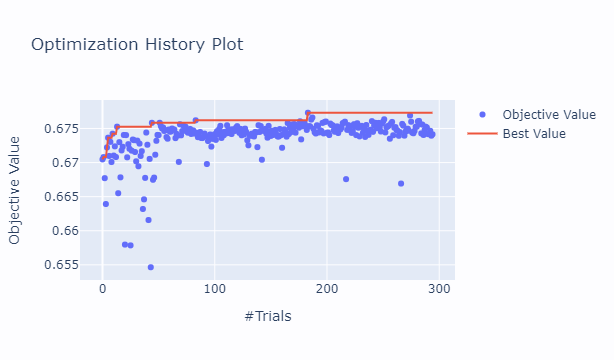

In [45]:
# history
optuna.visualization.plot_optimization_history(study)

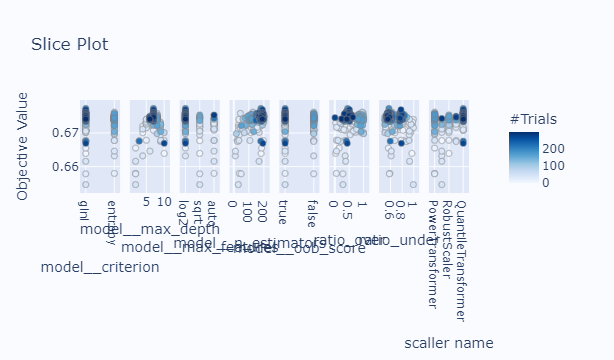

In [46]:
# Visualize individual hyperparameters as slice plot.
optuna.visualization.plot_slice(study)

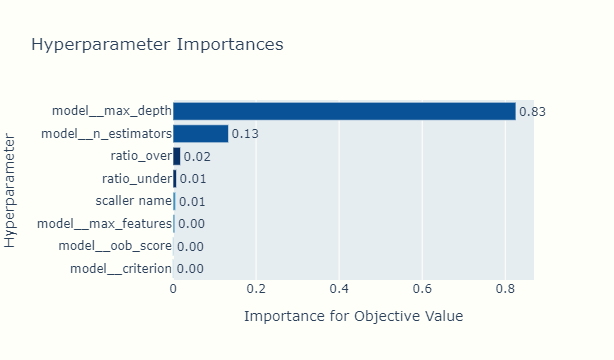

In [47]:
# Visualize parameter importances. 
optuna.visualization.plot_param_importances(study)

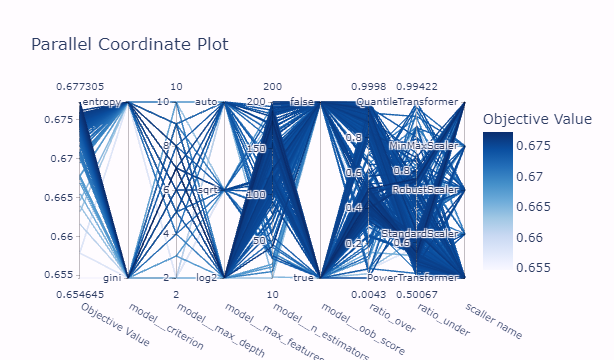

In [48]:
# Space search visualisation
optuna.visualization.plot_parallel_coordinate(study)

In [49]:
# Delete the temporary cache before exiting
# memory.clear(warn=False)
# rmtree(location)

## Meilleure solution

In [50]:
# Load best params from last search from file
# study=joblib.load(file_name)
best = study.best_params

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.6773052025674776
  Params: 
    ratio_over: 0.44477364180855467
    ratio_under: 0.5713605874395502
    scaller name: QuantileTransformer
    model__max_depth: 7
    model__n_estimators: 180
    model__criterion: gini
    model__max_features: log2
    model__oob_score: True


Class balance on fitting model step : Counter({0: 91843, 1: 13091})
TRAIN
               precision    recall  f1-score   support

           0       0.96      0.71      0.82    122460
           1       0.17      0.69      0.27     10473

    accuracy                           0.71    132933
   macro avg       0.57      0.70      0.54    132933
weighted avg       0.90      0.71      0.78    132933

 Scores  on train : {'COST': 0.674362438833594, 'AUC': 0.7372555992705871}
TEST
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     30616
           1       0.16      0.64      0.25      2618

    accuracy                           0.70     33234
   macro avg       0.56      0.67      0.53     33234
weighted avg       0.90      0.70      0.77     33234

 Scores  on test : {'COST': 0.6739348903682432}


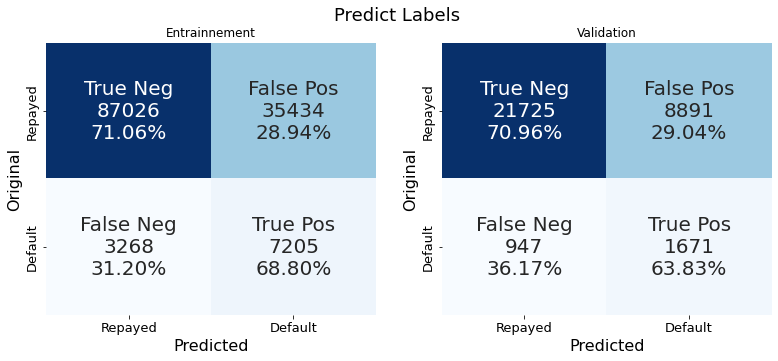

In [51]:
# print best results
# print('Best custom_score = {} for {}'.format(study.best_value,best))

# Initialize params
params = {}


# Variance space
# params['variance__threshold'] = best['variance']

# ratios for samplers
o_r = best['ratio_over']
u_r = best['ratio_under']

#over sampling
params['over__sampling_strategy'] =  ratio_initial *(1 + o_r)

# under sampling
params['under__sampling_strategy'] = ratio_initial *(1 + o_r)/( u_r)
    
# sample weight
# x = best['weight']  # MODIFIE
# params['model__class_weight'] = {0 : 1-x, 1 : x}
params['model__class_weight'] = 'balanced'

# Scaller space
scaler_name = best['scaller name']

if scaler_name == 'MinMaxScaler':
    params['scaler'] = mmx
elif scaler_name == 'StandardScaler':
    params['scaler'] =  std   
elif scaler_name == 'QuantileTransformer':
    params['scaler'] =  qt
elif scaler_name == 'RobustScaler':
    params['scaler'] =  rob
elif scaler_name == 'PowerTransformer':
    params['scaler'] =  pwt  
         
# Random Forest space       
params['model__max_depth'] = best['model__max_depth']
params['model__n_estimators'] = best['model__n_estimators']
params['model__criterion'] = best['model__criterion']
params['model__max_features'] = best['model__max_features']
# params['model__warm_start'] = best['model__warm_start']
params['model__oob_score'] = best['model__oob_score']

# set and fit with best params
pipe_optim.set_params(**params)
pipe_optim.fit(train, train_true)

# Count effective classes
print('Class balance on fitting model step : %s' % Counter(pipe_samplers[0:2].fit_resample(train,train_true)[1]))
if LOG:
    run['Modele/[Optimisation]/Classe efectives'].log(str(Counter(pipe_samplers[0:2].fit_resample(train,train_true)[1])))


# print evaluation summary
evaluate_estimator(pipe_optim,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Optimisation]/'))


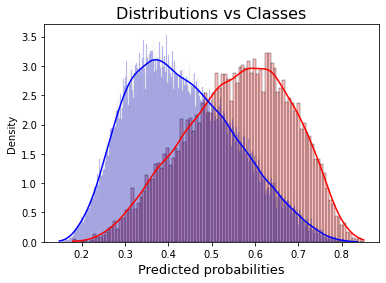

In [52]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = pipe_optim.predict_proba(train)
proba_distributions(train_true,train_predicted_probas,(LOG,run,'Modele/[Optimisation]/Train'))

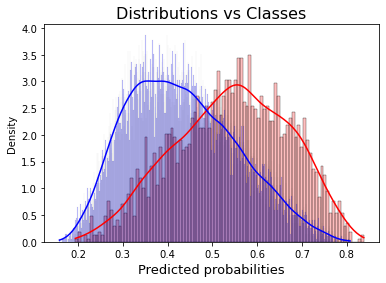

In [53]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = pipe_optim.predict_proba(test)
proba_distributions(test_true,test_predicted_probas,(LOG,run,'Modele/[Optimisation]/Test'))

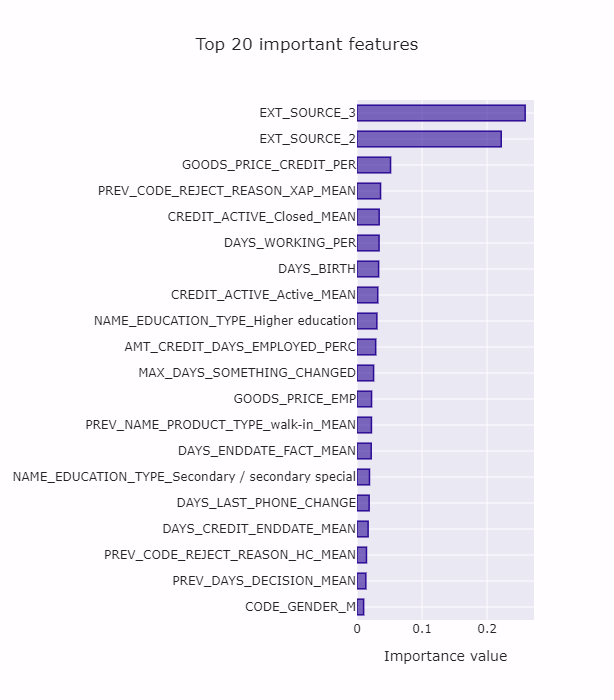

In [54]:
# Feature importance
feature_importance_plot(pipe_optim[-1].feature_importances_,train,(LOG,run,'Modele/[Optimisation]/'))

# Récapitulatif des scores

In [55]:
import ast
# List of all experiment logged to Neptune ai
steps =['[Out of bag]','[Under]','[Over]','[Balance]','[Samplers & Weight]','[Optimisation]']
# create lists to retain fetched logs
train_costs, train_aucs, test_costs, names = list(), list(), list(), list()
# ierate throught logs
for step in steps:
    names.append('Random Forest '+step)
    train_scores = ast.literal_eval(run['Modele/'+step+'/Train scores'].fetch_last())
    test_score = ast.literal_eval(run['Modele/'+step+'/Test scores'].fetch_last())
    train_costs.append(train_scores['COST'])
    train_aucs.append(train_scores['AUC'])
    test_costs.append(test_score['COST'])

# create results Data Frame
results = pd.DataFrame({'Model name'   : names,
                        'Cost on train': train_costs,
                        'Auc on train' : train_aucs,
                        'Cost on test' : test_costs,
                       }
                      )
joblib.dump(results, 'Results/rf.results')
results.style.highlight_max()

,Model name,Cost on train,Auc on train,Cost on test
0,Random Forest [Out of bag],0.501989,0.712528,0.501970
1,Random Forest [Under],0.673418,0.732286,0.669826
2,Random Forest [Over],0.505893,0.720975,0.506937
3,Random Forest [Balance],0.500439,0.717160,0.500524
4,Random Forest [Samplers & Weight],0.503469,0.723905,0.503684
5,Random Forest [Optimisation],0.674362,0.737256,0.673935


# Sauvegarde du modèle pour dasboard

modèle fitté sur toutes les données disponibles

In [56]:
# Set the filename
save_path = 'Models/'
name= 'random_forest_optimized_fitted'
file_name = name+'.mod'

# Fit on whole datas
pipe = clone(pipe_optim)
pipe.fit(features.drop('TARGET', axis=1), features.TARGET)

# Write on disk
joblib.dump(pipe, save_path+file_name, compress=('lzma',3))

if LOG:
    run['Best fitted model on all features jobilb'].upload(File(save_path+file_name))

In [57]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 2 operations (0.00% done). Please wait.


All 2 operations synced, thanks for waiting!
